In [1]:
import os
import librosa
import numpy as np
import librosa.display

# Function to preprocess audio files and convert to Mel spectrogram
def process_mp3_to_mel(input_folder, output_folder, sample_rate=22050, duration=15, n_mels=128):
    """
    Reads MP3 files from the input folder, converts them to Mel spectrograms,
    applies preprocessing (clipping/padding to fixed duration), and saves the results.

    Parameters:
        input_folder (str): Path to the folder containing MP3 files.
        output_folder (str): Path to save the resulting Mel spectrograms.
        sample_rate (int): Sampling rate for audio files. Default is 22050 Hz.
        duration (int): Duration in seconds to which audio files are clipped/padded.
        n_mels (int): Number of Mel bands to generate. Default is 128.

    Returns:
        None
    """
    # Ensure output folder exists
    os.makedirs(output_folder, exist_ok=True)

    fixed_length = sample_rate * duration  # Fixed length in samples

    for root, _, files in os.walk(input_folder):
        for file in files:
            if file.endswith(".mp3"):
                file_path = os.path.join(root, file)
                try:
                    # Load the audio file
                    audio, sr = librosa.load(file_path, sr=sample_rate, mono=True)

                    # Clip or pad the audio to the fixed length
                    if len(audio) > fixed_length:
                        audio = audio[:fixed_length]
                    else:
                        audio = np.pad(audio, (0, max(0, fixed_length - len(audio))), mode='constant')

                    # Generate the Mel spectrogram
                    mel_spectrogram = librosa.feature.melspectrogram(
                        y=audio, sr=sr, n_mels=n_mels, fmax=sr // 2
                    )

                    # Convert to log scale (dB)
                    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

                    # Save the spectrogram as a numpy file
                    output_file_name = os.path.splitext(file)[0] + ".npy"
                    output_file_path = os.path.join(output_folder, output_file_name)
                    np.save(output_file_path, log_mel_spectrogram)

                    print(f"Processed and saved: {output_file_path}")
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

# Example usage
# process_mp3_to_mel('path/to/input/folder', 'path/to/output/folder')

In [2]:
#process_mp3_to_mel('/kaggle/input/fma-tiny/fma_copy/fma_small', '/kaggle/input/fma-tiny/fma_copy/fma_processed')

In [5]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Custom Dataset for Mel Spectrograms
class MelSpectrogramDataset(Dataset):
    def __init__(self, folder_path):
        self.file_paths = [
            os.path.join(folder_path, f) 
            for f in os.listdir(folder_path) 
            if f.endswith('.npy')
        ]
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        mel_spectrogram = np.load(self.file_paths[idx])
        # Expand dimensions to match model input (channels, height, width)
        mel_spectrogram = np.expand_dims(mel_spectrogram, axis=0)
        return torch.FloatTensor(mel_spectrogram)

# ResidualBlock (same as in your provided code)
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, kernel_size=3),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, kernel_size=3),
            nn.InstanceNorm2d(in_channels)
        )
    
    def forward(self, x):
        return x + self.block(x)

# Generator (same as in your provided code)
class Generator(nn.Module):
    def __init__(self, input_channels=1, output_channels=1):
        super(Generator, self).__init__()
        
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_channels, 32, kernel_size=7),
            nn.InstanceNorm2d(32),
            nn.ReLU(inplace=True)
        ]
        
        in_channels = 32
        for _ in range(1):
            out_channels = in_channels * 2
            model += [
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ]
            in_channels = out_channels
        
        for _ in range(3):
            model += [ResidualBlock(in_channels)]
        
        for _ in range(1):
            out_channels = in_channels // 2
            model += [
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ]
            in_channels = out_channels
        
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels, output_channels, kernel_size=7),
            nn.Tanh()
        ]
        
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        return self.model(x)

# Discriminator (same as in your provided code)
class Discriminator(nn.Module):
    def __init__(self, input_channels=1):
        super(Discriminator, self).__init__()
        
        model = [
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        
        in_channels = 64
        for _ in range(3):
            out_channels = min(in_channels * 2, 512)
            model += [
                nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.LeakyReLU(0.2, inplace=True)
            ]
            in_channels = out_channels
        
        model += [
            nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1)
        ]
        
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        return self.model(x)

# CycleGAN Training
class MusicStyleTransferCycleGAN:
    def __init__(self, source_folder, target_folder, device='cuda'):
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        
        # Load datasets
        source_dataset = MelSpectrogramDataset(source_folder)
        target_dataset = MelSpectrogramDataset(target_folder)
        
        self.source_loader = DataLoader(source_dataset, batch_size=4, shuffle=True)
        self.target_loader = DataLoader(target_dataset, batch_size=4, shuffle=True)
        
        # Initialize generators and discriminators
        self.G_source_to_target = Generator().to(self.device)
        self.G_target_to_source = Generator().to(self.device)
        self.D_source = Discriminator().to(self.device)
        self.D_target = Discriminator().to(self.device)
        
        # Optimizers
        self.g_optimizer = optim.Adam(
            list(self.G_source_to_target.parameters()) + 
            list(self.G_target_to_source.parameters()), 
            lr=0.0002, betas=(0.5, 0.999)
        )
        self.d_source_optimizer = optim.Adam(self.D_source.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.d_target_optimizer = optim.Adam(self.D_target.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
        # Losses
        self.adversarial_loss = nn.MSELoss()
        self.cycle_consistency_loss = nn.L1Loss()
        self.identity_loss = nn.L1Loss()
        
        # Tracking losses
        self.epoch_losses = {
            'g_total': [],
            'd_source': [],
            'd_target': []
        }

    def save_models(self, save_dir='model_checkpoints'):
        """
        Save weights for all models in the CycleGAN.
        
        Args:
            save_dir (str): Directory to save model checkpoints
        """
        # Create directory if it doesn't exist
        os.makedirs(save_dir, exist_ok=True)
        
        # Saving generator models
        torch.save(self.G_source_to_target.state_dict(), 
                   os.path.join(save_dir, 'generator_source_to_target.pth'))
        torch.save(self.G_target_to_source.state_dict(), 
                   os.path.join(save_dir, 'generator_target_to_source.pth'))
        
        # Saving discriminator models
        torch.save(self.D_source.state_dict(), 
                   os.path.join(save_dir, 'discriminator_source.pth'))
        torch.save(self.D_target.state_dict(), 
                   os.path.join(save_dir, 'discriminator_target.pth'))
        
        print(f"Model weights saved to {save_dir}")

    def load_models(self, save_dir='model_checkpoints'):
        """
        Load weights for all models in the CycleGAN.
        
        Args:
            save_dir (str): Directory containing model checkpoints
        """
        try:
            # Loading generator models
            self.G_source_to_target.load_state_dict(
                torch.load(os.path.join(save_dir, 'generator_source_to_target.pth'))
            )
            self.G_target_to_source.load_state_dict(
                torch.load(os.path.join(save_dir, 'generator_target_to_source.pth'))
            )
            
            # Loading discriminator models
            self.D_source.load_state_dict(
                torch.load(os.path.join(save_dir, 'discriminator_source.pth'))
            )
            self.D_target.load_state_dict(
                torch.load(os.path.join(save_dir, 'discriminator_target.pth'))
            )
            
            print(f"Model weights loaded from {save_dir}")
        except FileNotFoundError:
            print(f"Error: Model checkpoint files not found in {save_dir}")
        except Exception as e:
            print(f"Error loading model weights: {e}")
    
    def train(self, epochs=10):
        for epoch in range(epochs):
            g_total_loss = 0
            d_source_loss = 0
            d_target_loss = 0
            
            for source_real, target_real in zip(self.source_loader, self.target_loader):
                source_real = source_real.to(self.device)
                target_real = target_real.to(self.device)
                
                # Generator training
                self.g_optimizer.zero_grad()
                
                # Generate transformed images
                source_fake = self.G_source_to_target(source_real)
                target_fake = self.G_target_to_source(target_real)
                
                # Cycle consistency
                source_cycle = self.G_target_to_source(source_fake)
                target_cycle = self.G_source_to_target(target_fake)
                
                # Adversarial losses for generators
                source_adv_loss = self.adversarial_loss(
                    self.D_target(source_fake), 
                    torch.ones_like(self.D_target(source_fake))
                )
                target_adv_loss = self.adversarial_loss(
                    self.D_source(target_fake), 
                    torch.ones_like(self.D_source(target_fake))
                )
                
                # Cycle consistency losses
                cycle_source_loss = self.cycle_consistency_loss(source_cycle, source_real)
                cycle_target_loss = self.cycle_consistency_loss(target_cycle, target_real)
                
                # Identity losses
                identity_source_loss = self.identity_loss(
                    self.G_source_to_target(target_real), target_real
                )
                identity_target_loss = self.identity_loss(
                    self.G_target_to_source(source_real), source_real
                )
                
                # Total generator loss
                g_loss = (
                    source_adv_loss + target_adv_loss + 
                    10 * (cycle_source_loss + cycle_target_loss) + 
                    5 * (identity_source_loss + identity_target_loss)
                )
                
                g_loss.backward()
                self.g_optimizer.step()
                
                # Discriminator training
                self.d_source_optimizer.zero_grad()
                self.d_target_optimizer.zero_grad()
                
                # Source discriminator loss
                source_real_loss = self.adversarial_loss(
                    self.D_source(target_real), 
                    torch.ones_like(self.D_source(target_real))
                )
                source_fake_loss = self.adversarial_loss(
                    self.D_source(target_fake.detach()), 
                    torch.zeros_like(self.D_source(target_fake))
                )
                source_d_loss = (source_real_loss + source_fake_loss) / 2
                
                # Target discriminator loss
                target_real_loss = self.adversarial_loss(
                    self.D_target(source_real), 
                    torch.ones_like(self.D_target(source_real))
                )
                target_fake_loss = self.adversarial_loss(
                    self.D_target(source_fake.detach()), 
                    torch.zeros_like(self.D_target(source_fake))
                )
                target_d_loss = (target_real_loss + target_fake_loss) / 2
                
                source_d_loss.backward()
                target_d_loss.backward()
                self.d_source_optimizer.step()
                self.d_target_optimizer.step()
                
                # Track losses
                g_total_loss += g_loss.item()
                d_source_loss += source_d_loss.item()
                d_target_loss += target_d_loss.item()
            
            # Average epoch losses
            avg_g_loss = g_total_loss / len(self.source_loader)
            avg_d_source_loss = d_source_loss / len(self.source_loader)
            avg_d_target_loss = d_target_loss / len(self.source_loader)
            
            # Store epoch losses
            self.epoch_losses['g_total'].append(avg_g_loss)
            self.epoch_losses['d_source'].append(avg_d_source_loss)
            self.epoch_losses['d_target'].append(avg_d_target_loss)
            
            print(f"Epoch {epoch+1}/{epochs}")
            print(f"Generator Loss: {avg_g_loss:.4f}")
            print(f"Source Discriminator Loss: {avg_d_source_loss:.4f}")
            print(f"Target Discriminator Loss: {avg_d_target_loss:.4f}\n")
    
    def plot_losses(self):
        plt.figure(figsize=(12, 4))
        plt.subplot(131)
        plt.plot(self.epoch_losses['g_total'], label='Generator Total Loss')
        plt.title('Generator Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(132)
        plt.plot(self.epoch_losses['d_source'], label='Source Discriminator Loss')
        plt.title('Source Discriminator Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(133)
        plt.plot(self.epoch_losses['d_target'], label='Target Discriminator Loss')
        plt.title('Target Discriminator Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

# Example usage
# cycleGAN = MusicStyleTransferCycleGAN('path/to/source/melspectrograms', 'path/to/target/melspectrograms')
# cycleGAN.train(epochs=10)
# cycleGAN.plot_losses()

Epoch 1/25
Generator Loss: 1389.6011
Source Discriminator Loss: 0.5771
Target Discriminator Loss: 0.6991

Epoch 2/25
Generator Loss: 1377.5232
Source Discriminator Loss: 0.2727
Target Discriminator Loss: 0.2152

Epoch 3/25
Generator Loss: 1374.2102
Source Discriminator Loss: 0.1554
Target Discriminator Loss: 0.2264

Epoch 4/25
Generator Loss: 1373.1054
Source Discriminator Loss: 0.0466
Target Discriminator Loss: 0.0878

Epoch 5/25
Generator Loss: 1372.7263
Source Discriminator Loss: 0.0551
Target Discriminator Loss: 0.0426

Epoch 6/25
Generator Loss: 1372.4356
Source Discriminator Loss: 0.0374
Target Discriminator Loss: 0.0611

Epoch 7/25
Generator Loss: 1372.2431
Source Discriminator Loss: 0.0222
Target Discriminator Loss: 0.0349

Epoch 8/25
Generator Loss: 1372.0416
Source Discriminator Loss: 0.0254
Target Discriminator Loss: 0.0274

Epoch 9/25
Generator Loss: 1371.8690
Source Discriminator Loss: 0.0216
Target Discriminator Loss: 0.0183

Epoch 10/25
Generator Loss: 1371.7967
Source D

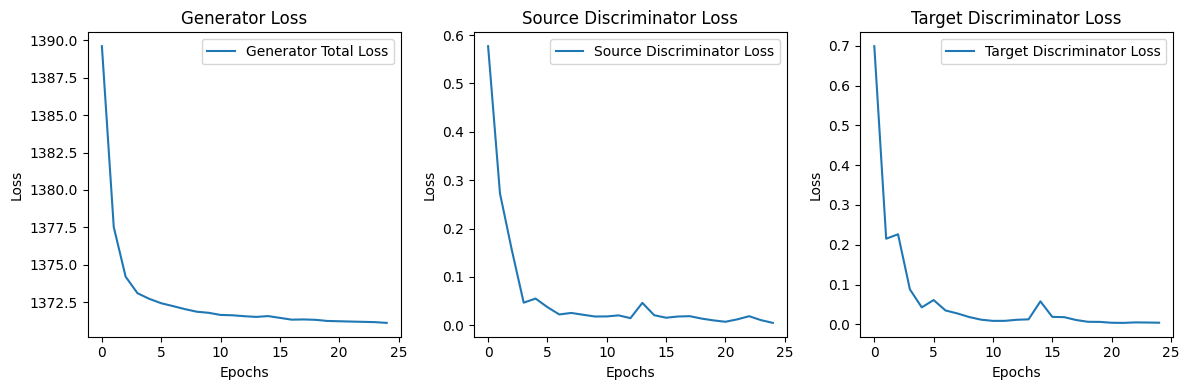

Model weights saved to my_model_checkpoints


In [6]:
cycleGAN = MusicStyleTransferCycleGAN('/kaggle/input/fma-processed/fma_processed', '/kaggle/input/fma-processed/fma_processed')
cycleGAN.train(epochs=25)
cycleGAN.plot_losses()
cycleGAN.save_models('my_model_checkpoints')

In [7]:
cycleGAN2 = MusicStyleTransferCycleGAN('/kaggle/input/fma-processed/fma_processed', '/kaggle/input/fma-processed/fma_processed')
cycleGAN2.load_models('my_model_checkpoints')

Model weights loaded from my_model_checkpoints


/tmp/ipykernel_23/3930450689.py:191: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(save_dir, 'generator_source_to_target.pth'))
/tmp/ipykernel_23/393